# Flax and Numpyro

https://omarfsosa.github.io/bayesian_nn

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns
from flax import linen as nn
from jax import random
from numpyro.contrib.module import flax_module
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive
from sklearn.preprocessing import StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

In [2]:
n = 200
rng_key, rng_subkey = random.split(rng_key)
x = random.uniform(rng_key, shape=(n,), minval=1, maxval=jnp.pi)
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

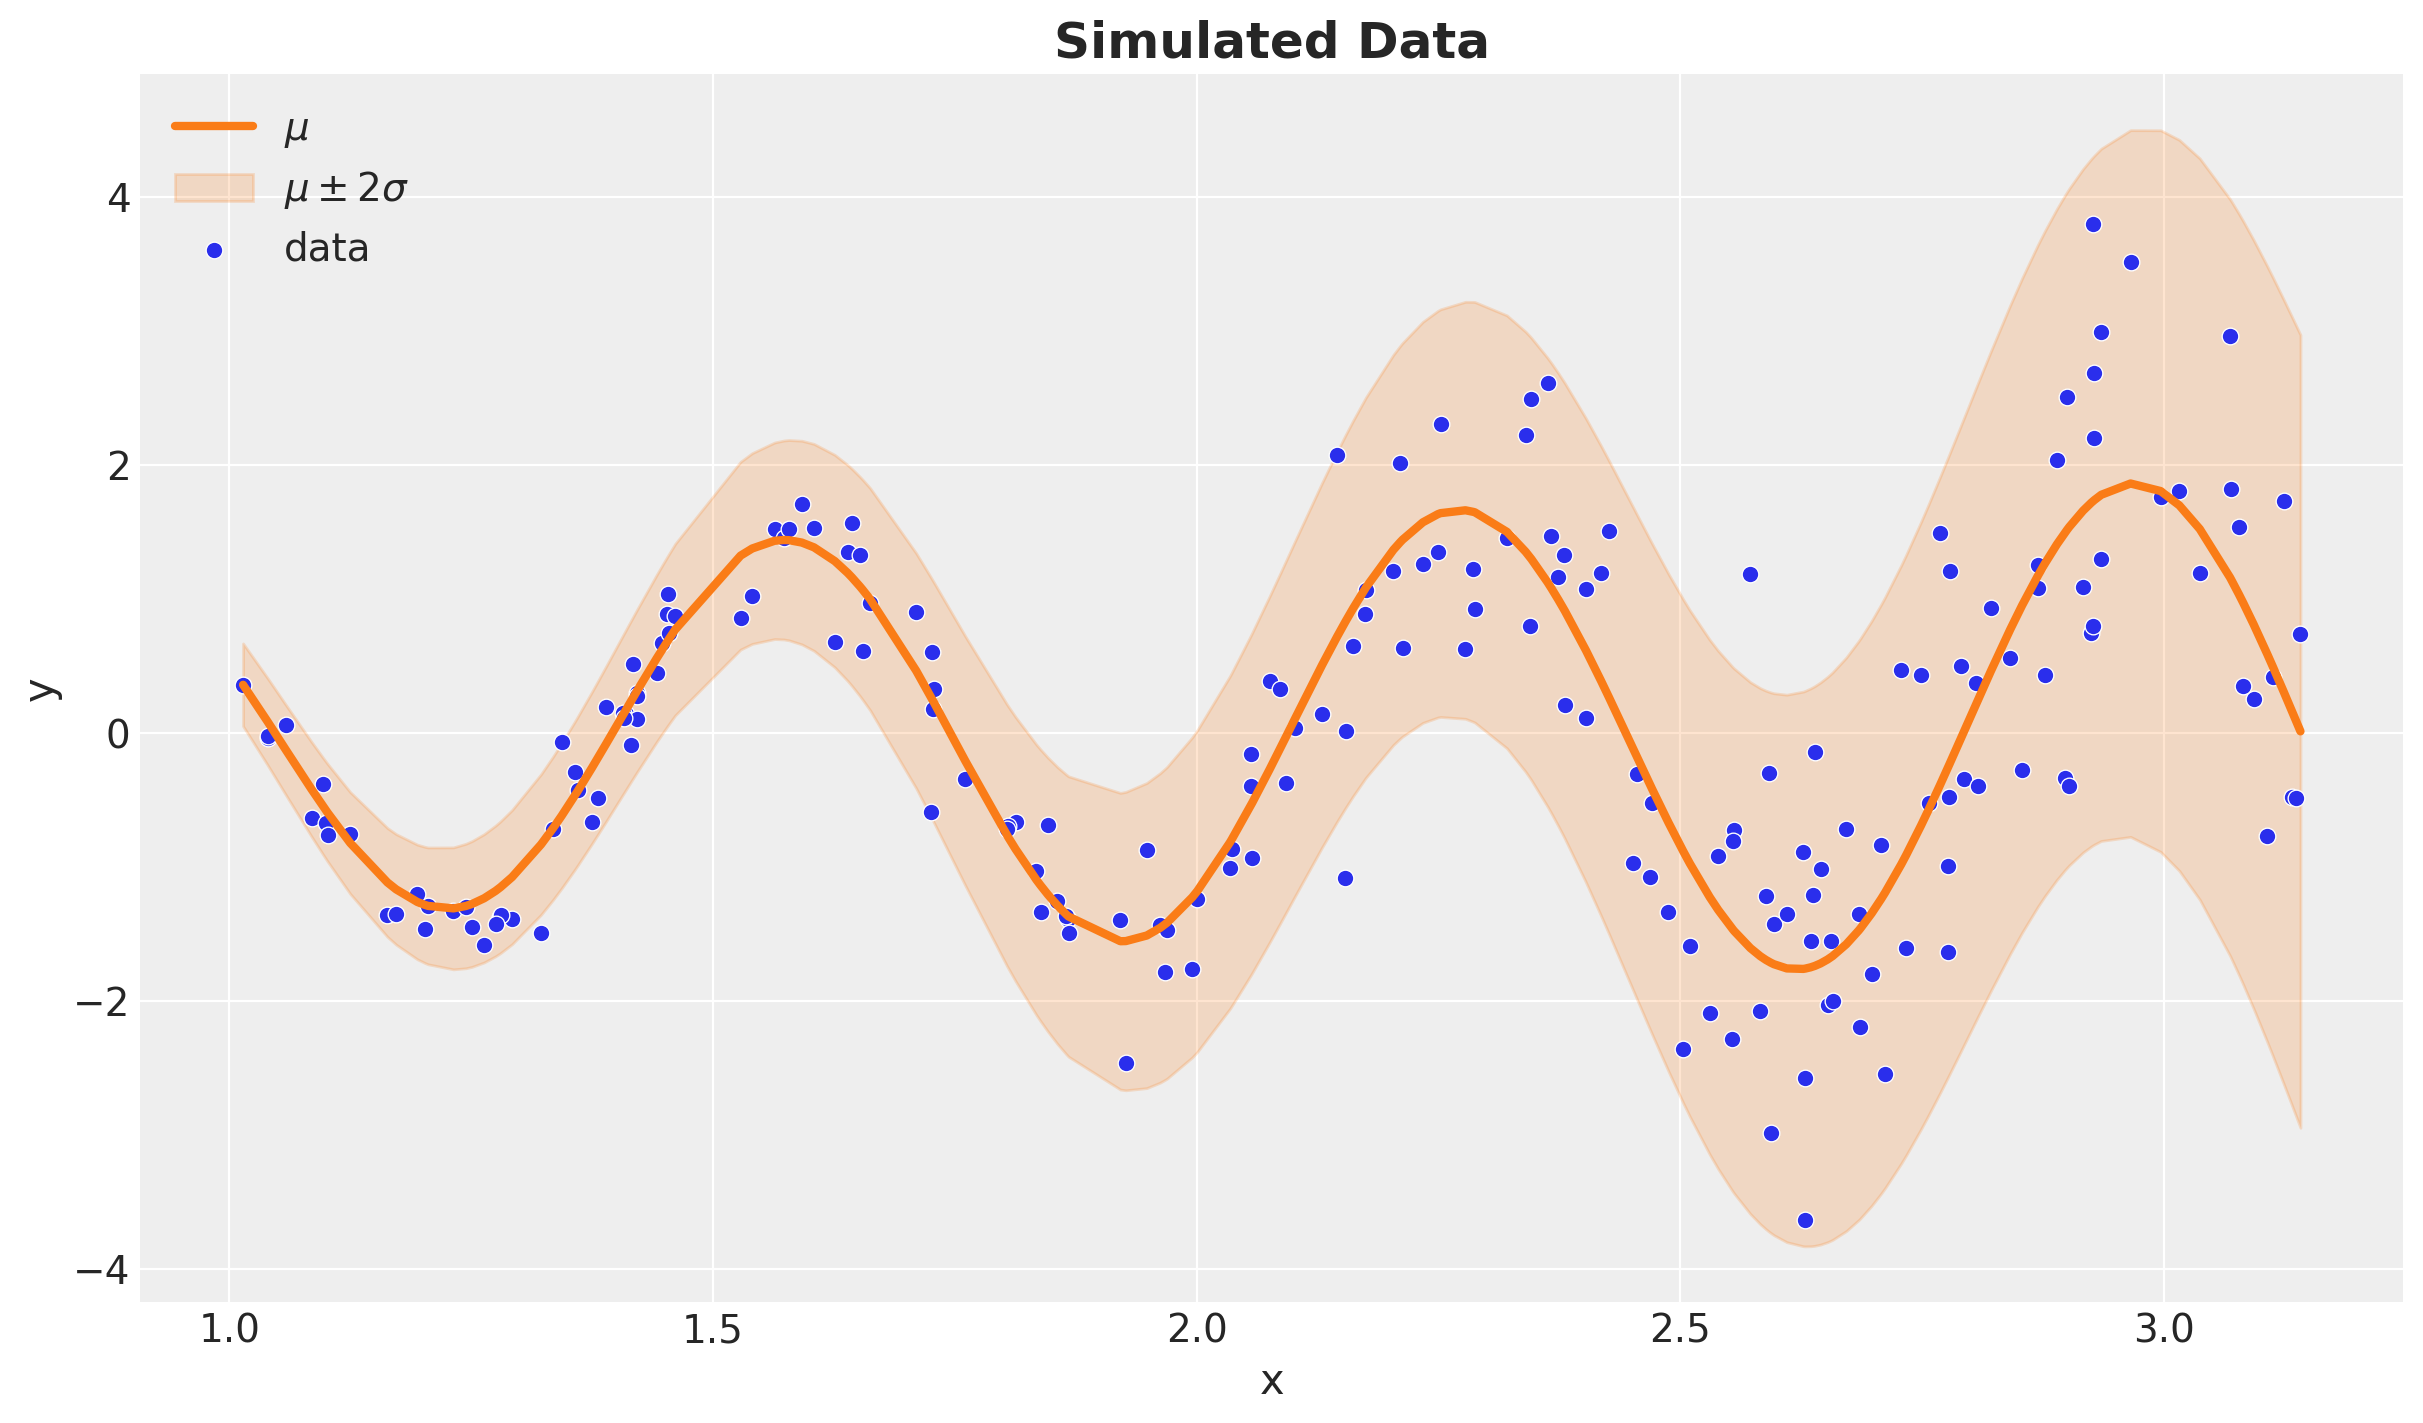

In [3]:
x_idx = jnp.argsort(x)

fig, ax = plt.subplots()
sns.lineplot(x=x, y=mu_true, color="C1", label=r"$\mu$", linewidth=3, ax=ax)
ax.fill_between(
    x[x_idx],
    (mu_true - 2 * sigma_true)[x_idx],
    (mu_true + 2 * sigma_true)[x_idx],
    color="C1",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
sns.scatterplot(x=x, y=y, color="C0", label="data", ax=ax)
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

In [4]:
train_test_split = 0.7
train_idx = int(n * train_test_split)
x_train, y_train = x[:train_idx], y[:train_idx]
x_test, y_test = x[train_idx:], y[train_idx:]

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

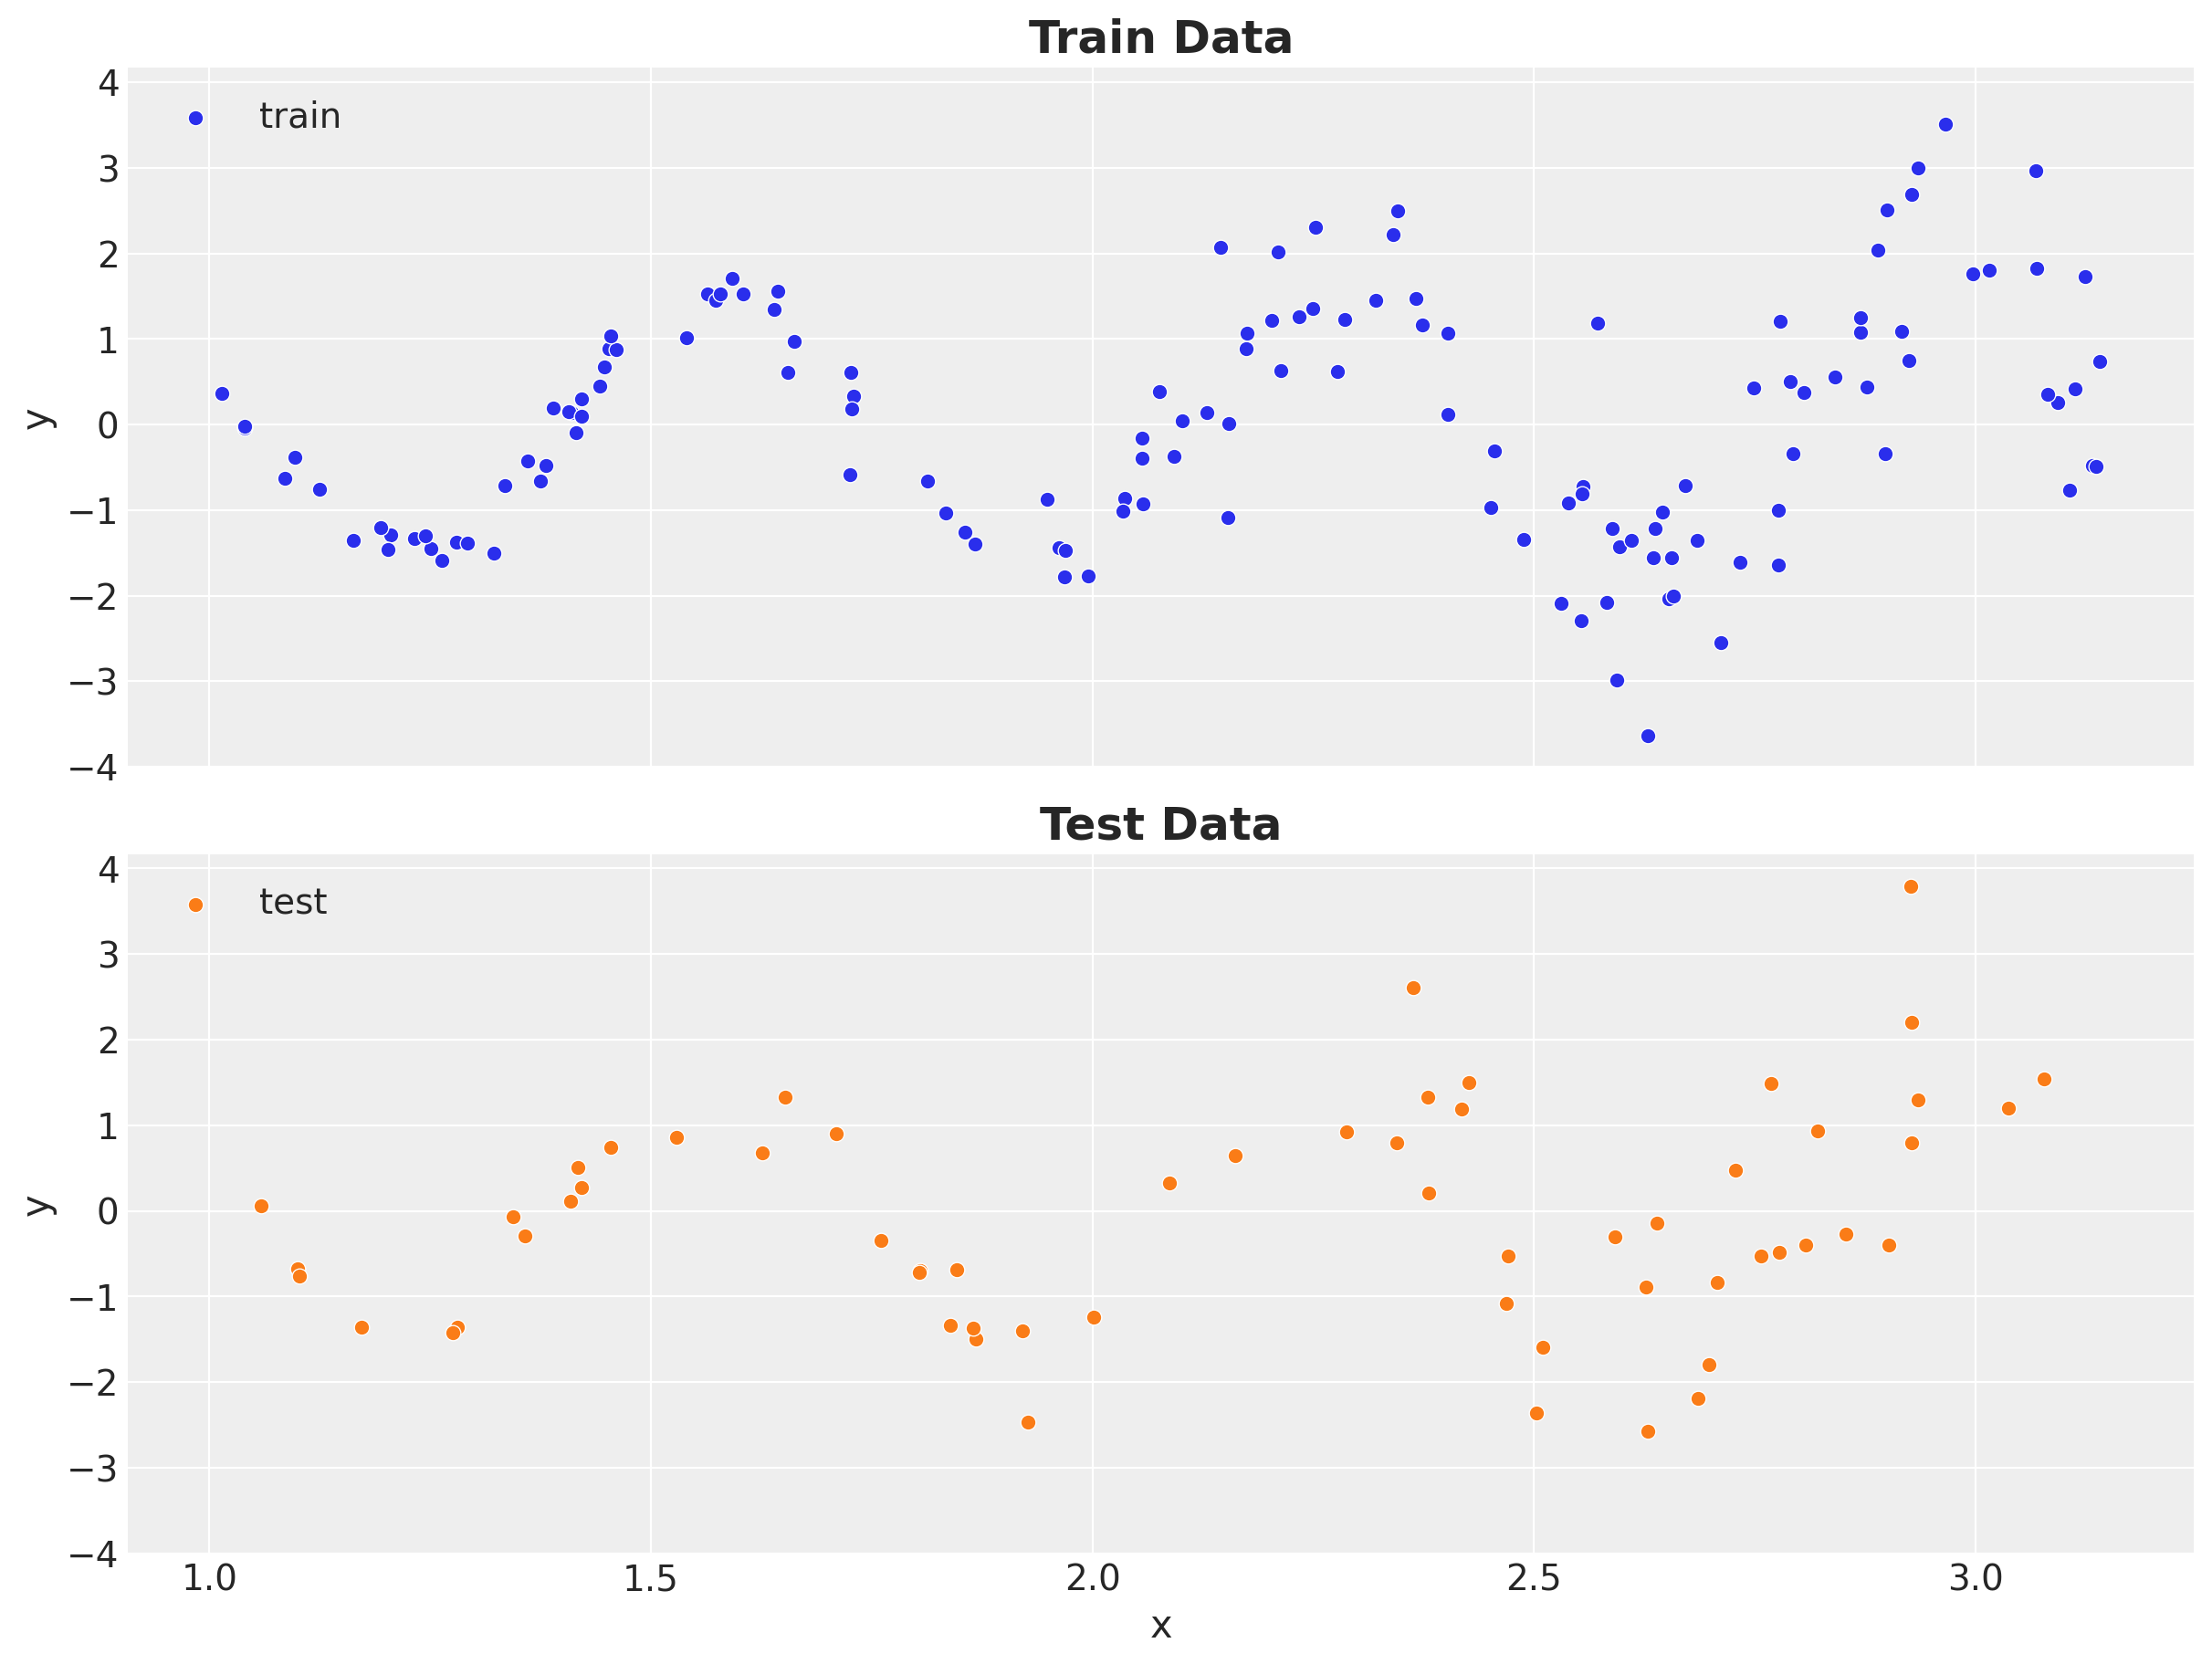

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(x=x_train, y=y_train, color="C0", label="train", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(x=x_test, y=y_test, color="C1", label="test", ax=ax[1])
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")

## Data Preprocessing

In [6]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train[:, None])
x_train_scaled = jnp.array(x_train_scaled)
x_test_scaled = x_scaler.transform(x_test[:, None])
x_test_scaled = jnp.array(x_test_scaled)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train[:, None])
y_train_scaled = y_train_scaled.squeeze()
y_train_scaled = jnp.array(y_train_scaled)
y_test_scaled = y_scaler.transform(y_test[:, None])
y_test_scaled = y_test_scaled.squeeze()
y_test_scaled = jnp.array(y_test_scaled)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

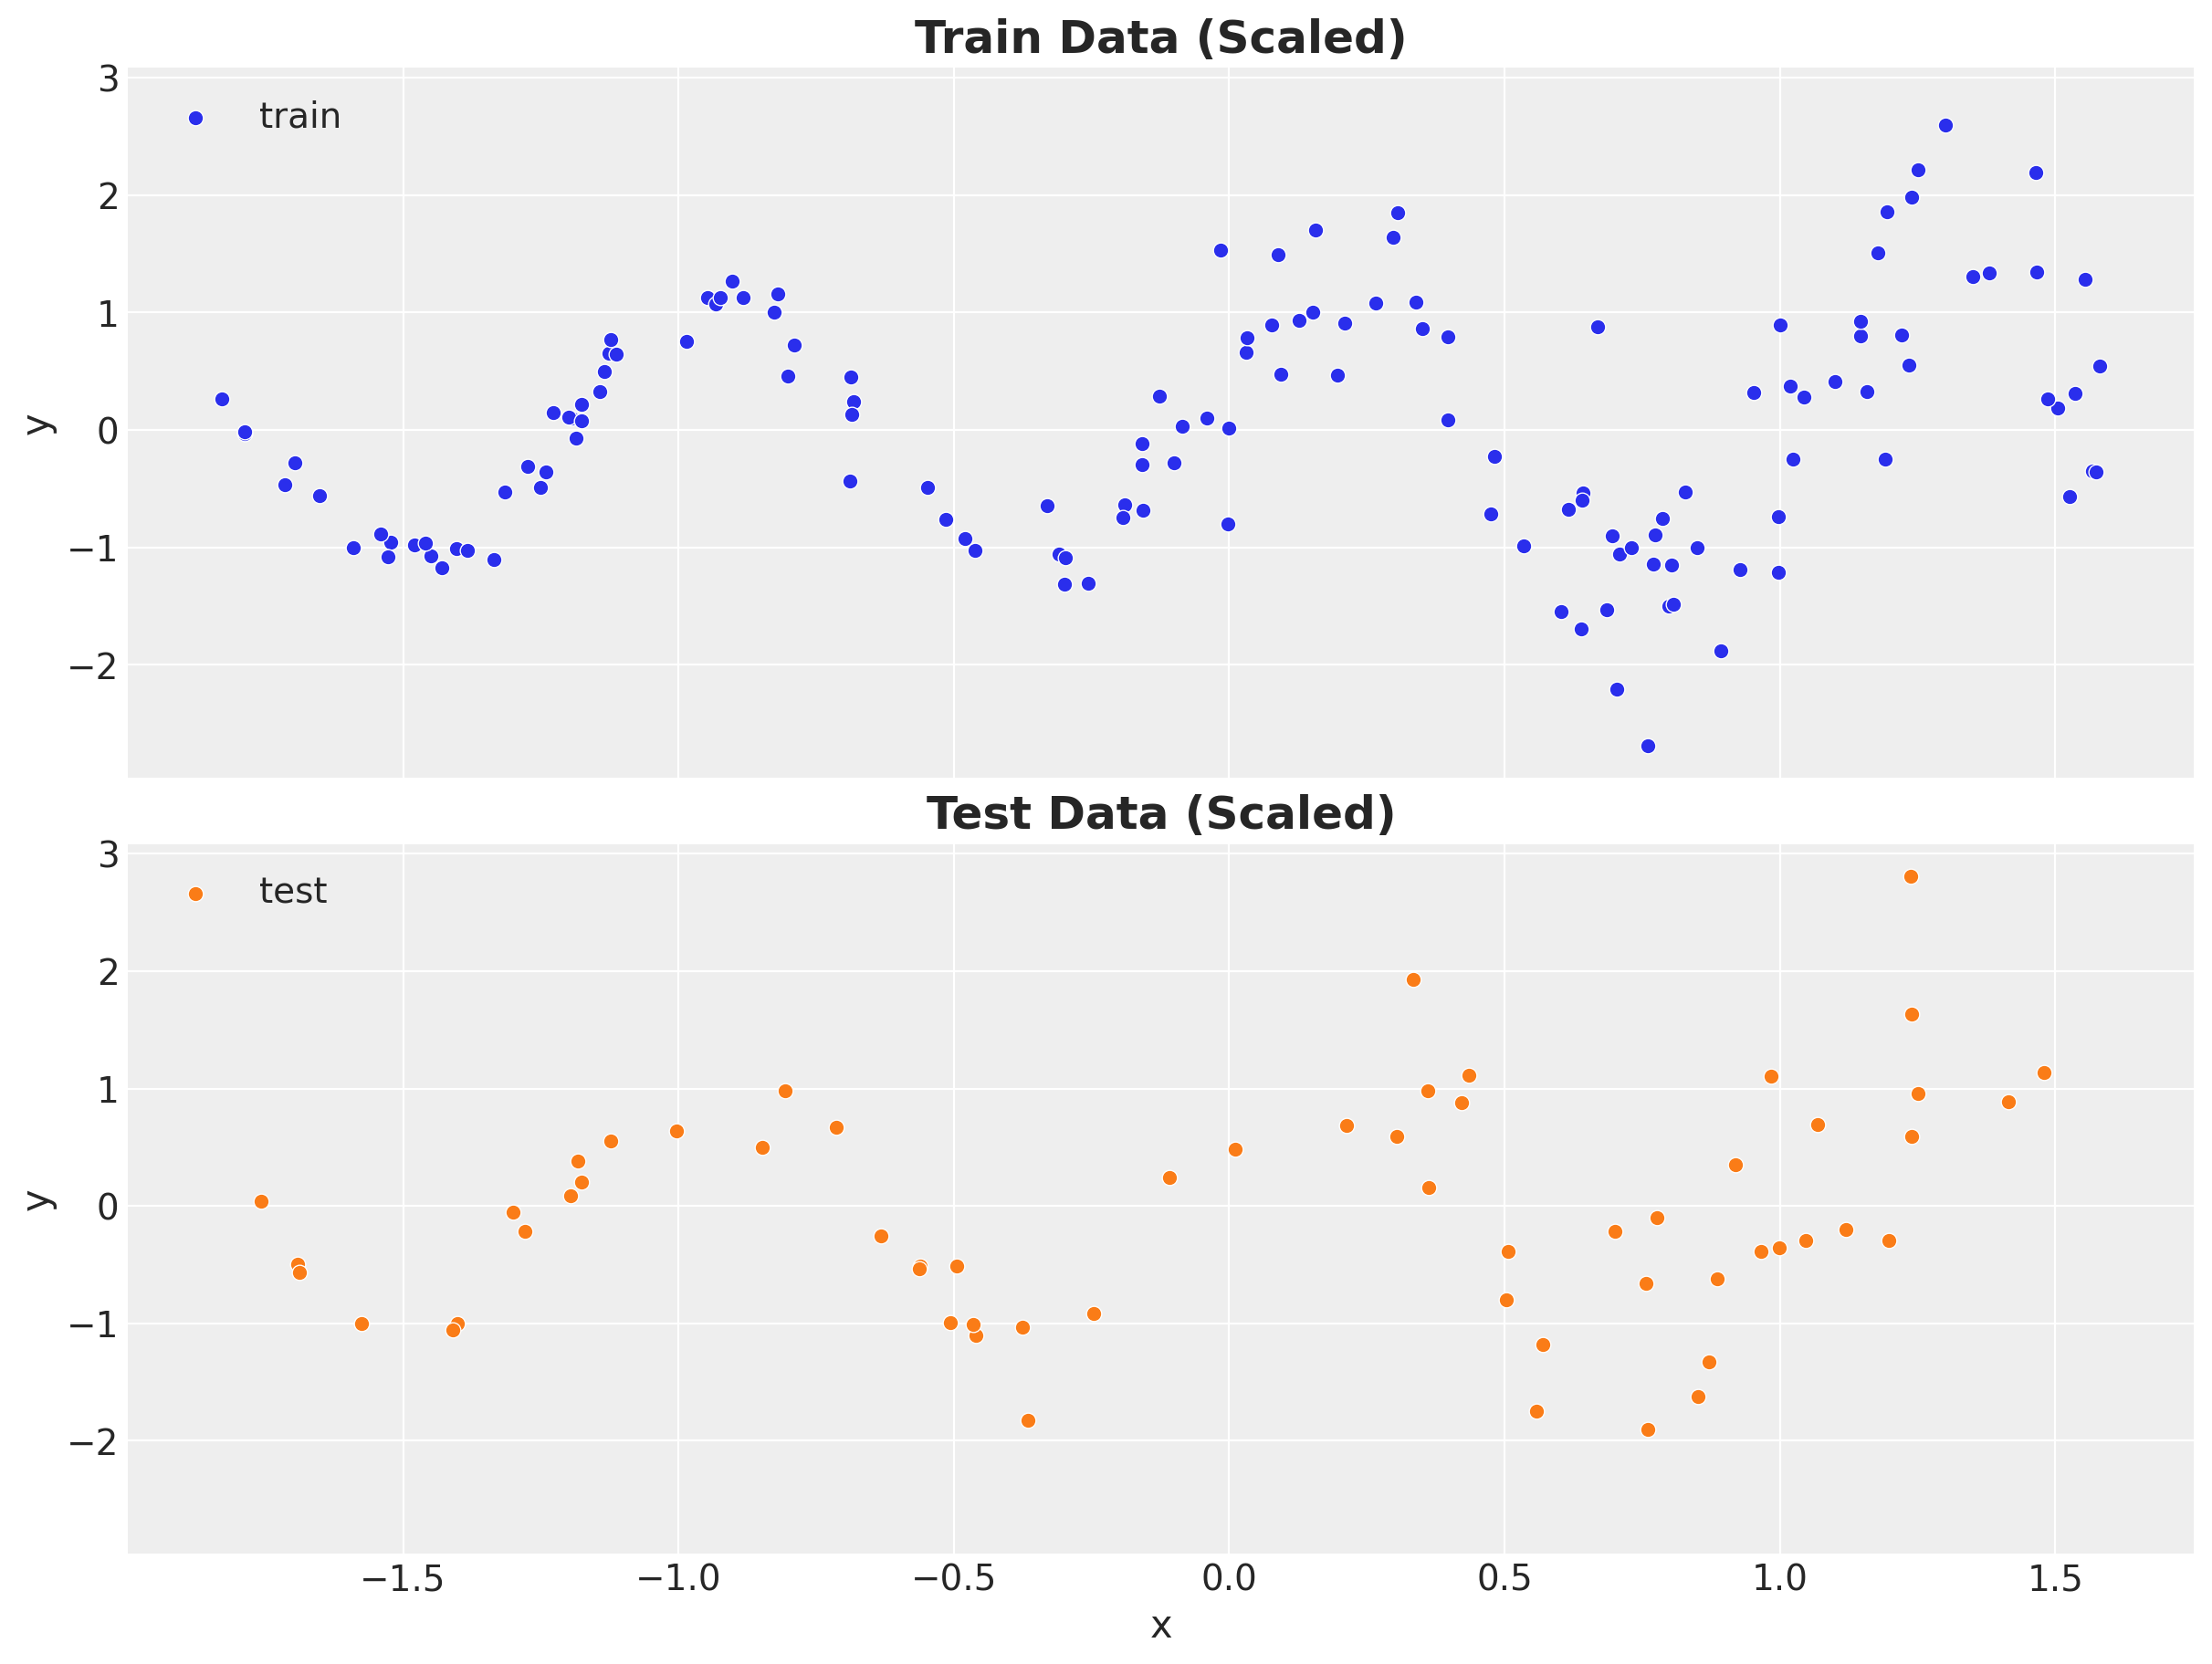

In [7]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(
    x=x_train_scaled.squeeze(),
    y=y_train_scaled,
    color="C0",
    label="train",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data (Scaled)", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(
    x=x_test_scaled.squeeze(),
    y=y_test_scaled,
    color="C1",
    label="test",
    ax=ax[1],
)
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data (Scaled)", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")

## Model Training

In [8]:
class MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for num_features in self.layers[:-1]:
            x = nn.sigmoid(nn.Dense(features=num_features)(x))
        return nn.Dense(features=self.layers[-1])(x)

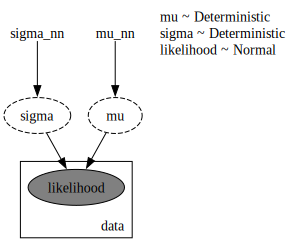

In [9]:
def model(x, y=None):
    mu_nn = flax_module("mu_nn", MLP(layers=[4, 4, 1]), input_shape=(1,))
    sigma_nn = flax_module("sigma_nn", MLP(layers=[2, 1]), input_shape=(1,))

    mu = numpyro.deterministic("mu", mu_nn(x).squeeze())
    sigma = numpyro.deterministic("sigma", jnp.exp(sigma_nn(x)).squeeze())

    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(loc=mu, scale=sigma), obs=y)


numpyro.render_model(
    model=model,
    model_args=(x_train_scaled, y_train_scaled.squeeze()),
    render_distributions=True,
    render_params=True,
)

100%|██████████| 4000/4000 [00:01<00:00, 2010.72it/s, init loss: 279.7086, avg. loss [3801-4000]: 64.0219]


Text(0.5, 1.0, 'ELBO loss')

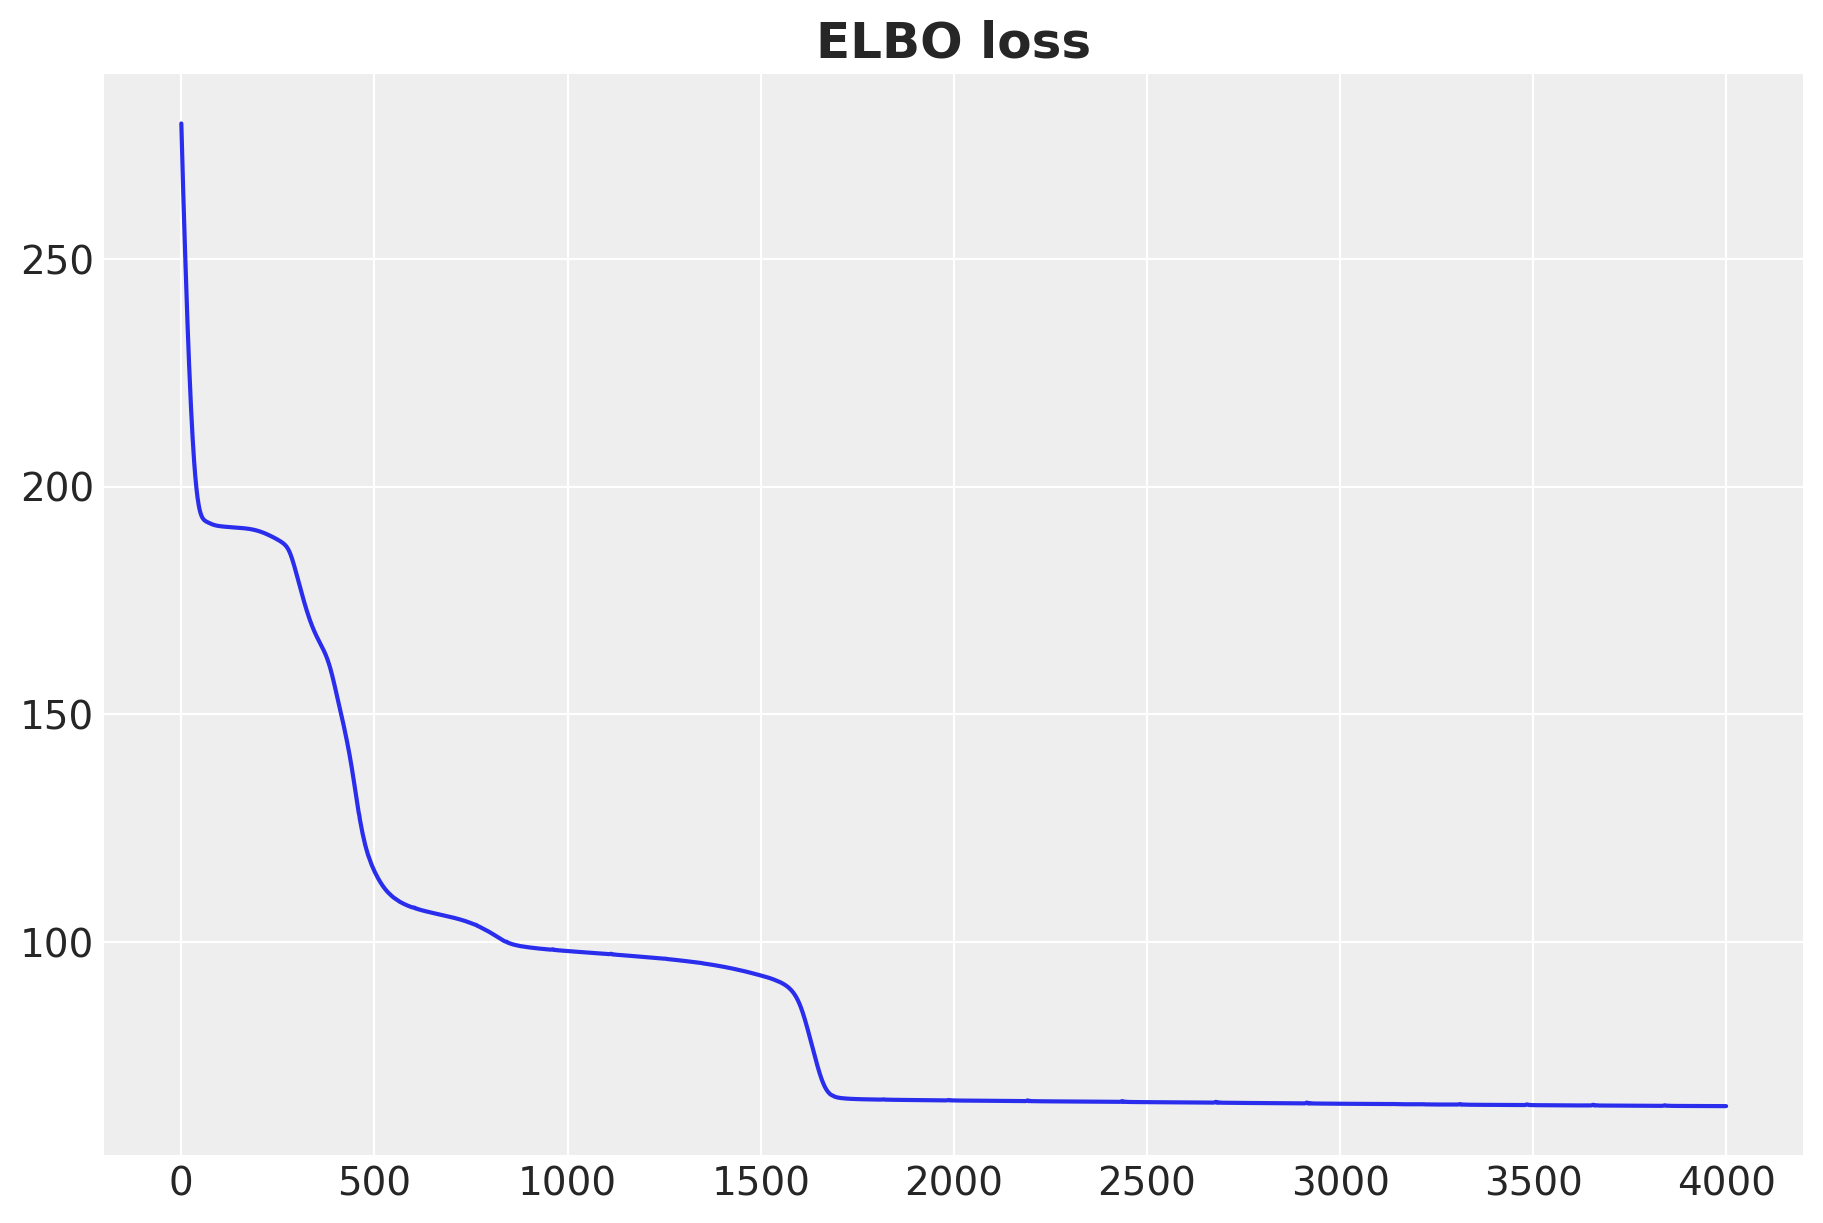

In [10]:
guide = AutoNormal(model=model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = random.split(key=rng_key)
n_samples = 4_000
svi_result = svi.run(rng_subkey, n_samples, x_train_scaled, y_train_scaled)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

In [11]:
params = svi_result.params
# get posterior samples (parameters)
predictive = Predictive(model=guide, params=params, num_samples=4_000)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_samples = predictive(rng_subkey, x_train_scaled, y_train_scaled)
# get posterior predictive (deterministics and likelihood)
predictive = Predictive(model=model, guide=guide, params=params, num_samples=4_000)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = predictive(rng_subkey, x_train_scaled)

In [12]:
idata_svi = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

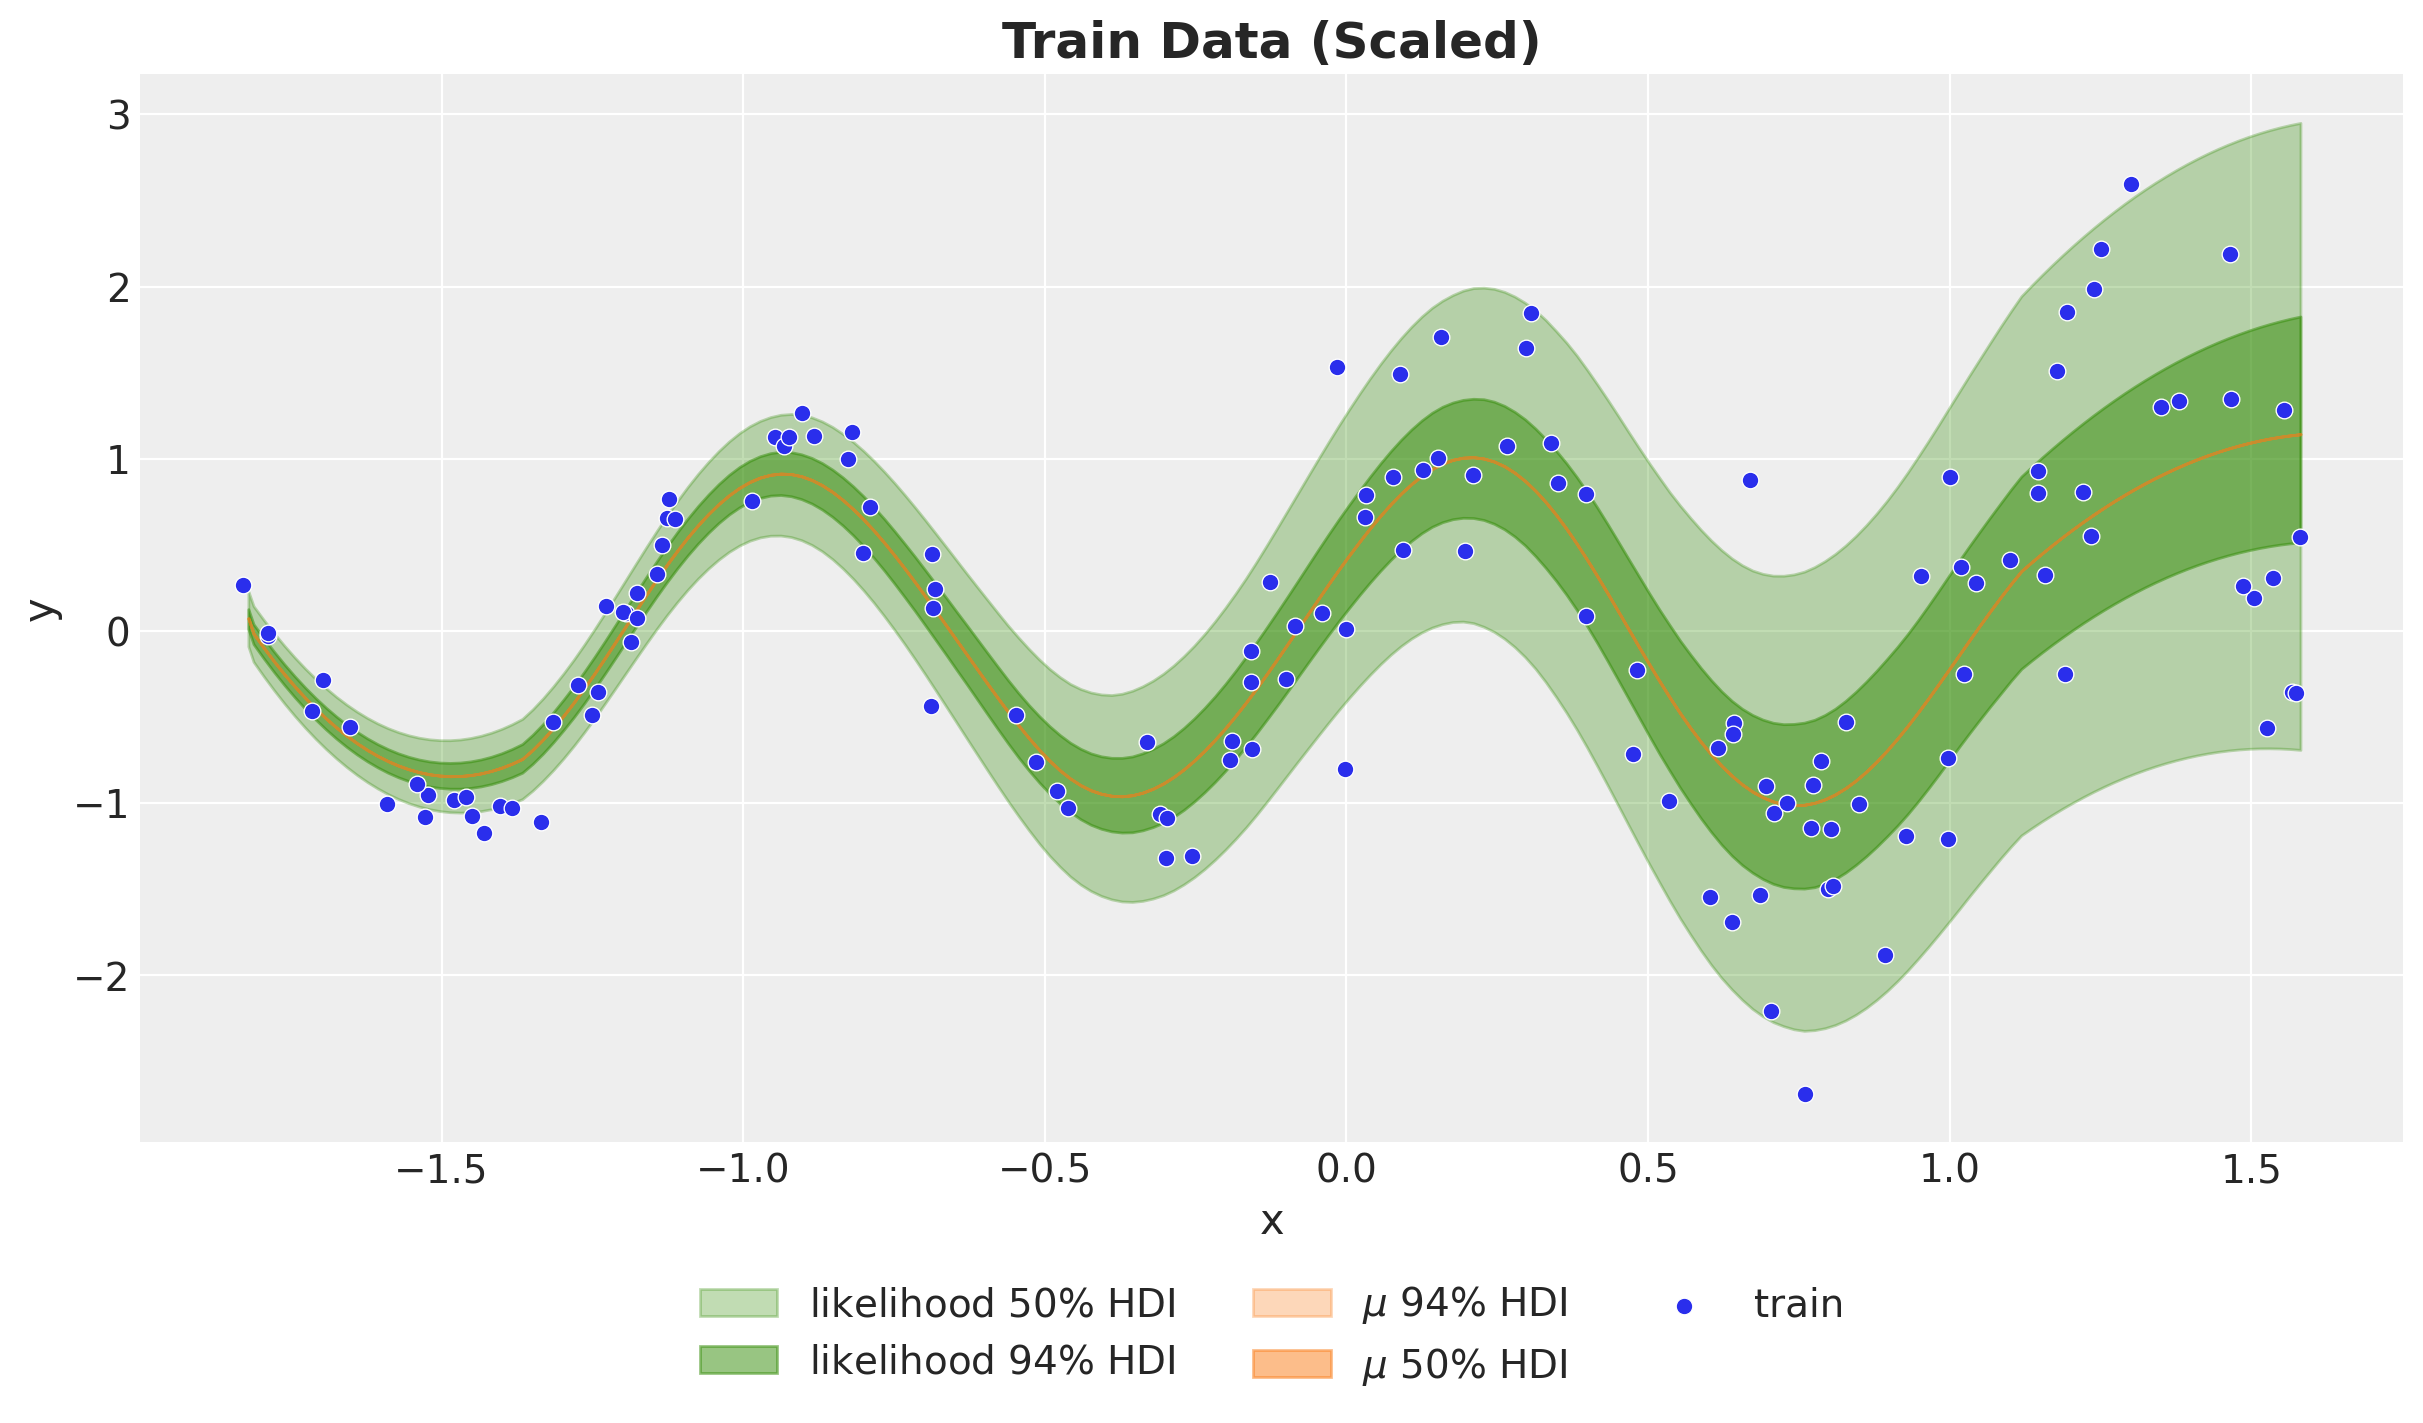

In [13]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=x_train_scaled.squeeze(),
    y=idata_svi.posterior_predictive["likelihood"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"label": r"likelihood $50\%$ HDI", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=x_train_scaled.squeeze(),
    y=idata_svi.posterior_predictive["likelihood"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"label": r"likelihood $94\%$ HDI", "alpha": 0.5},
    ax=ax,
)
az.plot_hdi(
    x=x_train_scaled.squeeze(),
    y=idata_svi.posterior_predictive["mu"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"label": r"$\mu$ $94\%$ HDI", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=x_train_scaled.squeeze(),
    y=idata_svi.posterior_predictive["mu"],
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"label": r"$\mu$ $50\%$ HDI", "alpha": 0.5},
    ax=ax,
)
sns.scatterplot(
    x=x_train_scaled.squeeze(),
    y=y_train_scaled,
    color="C0",
    label="train",
    ax=ax,
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_title(label="Train Data (Scaled)", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

In [14]:
predictive = Predictive(model=model, guide=guide, params=params, num_samples=4_000)
rng_key, rng_subkey = random.split(key=rng_key)
test_posterior_predictive_samples = predictive(rng_subkey, x_test_scaled)

test_idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_posterior_predictive_samples.items()
    },
)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

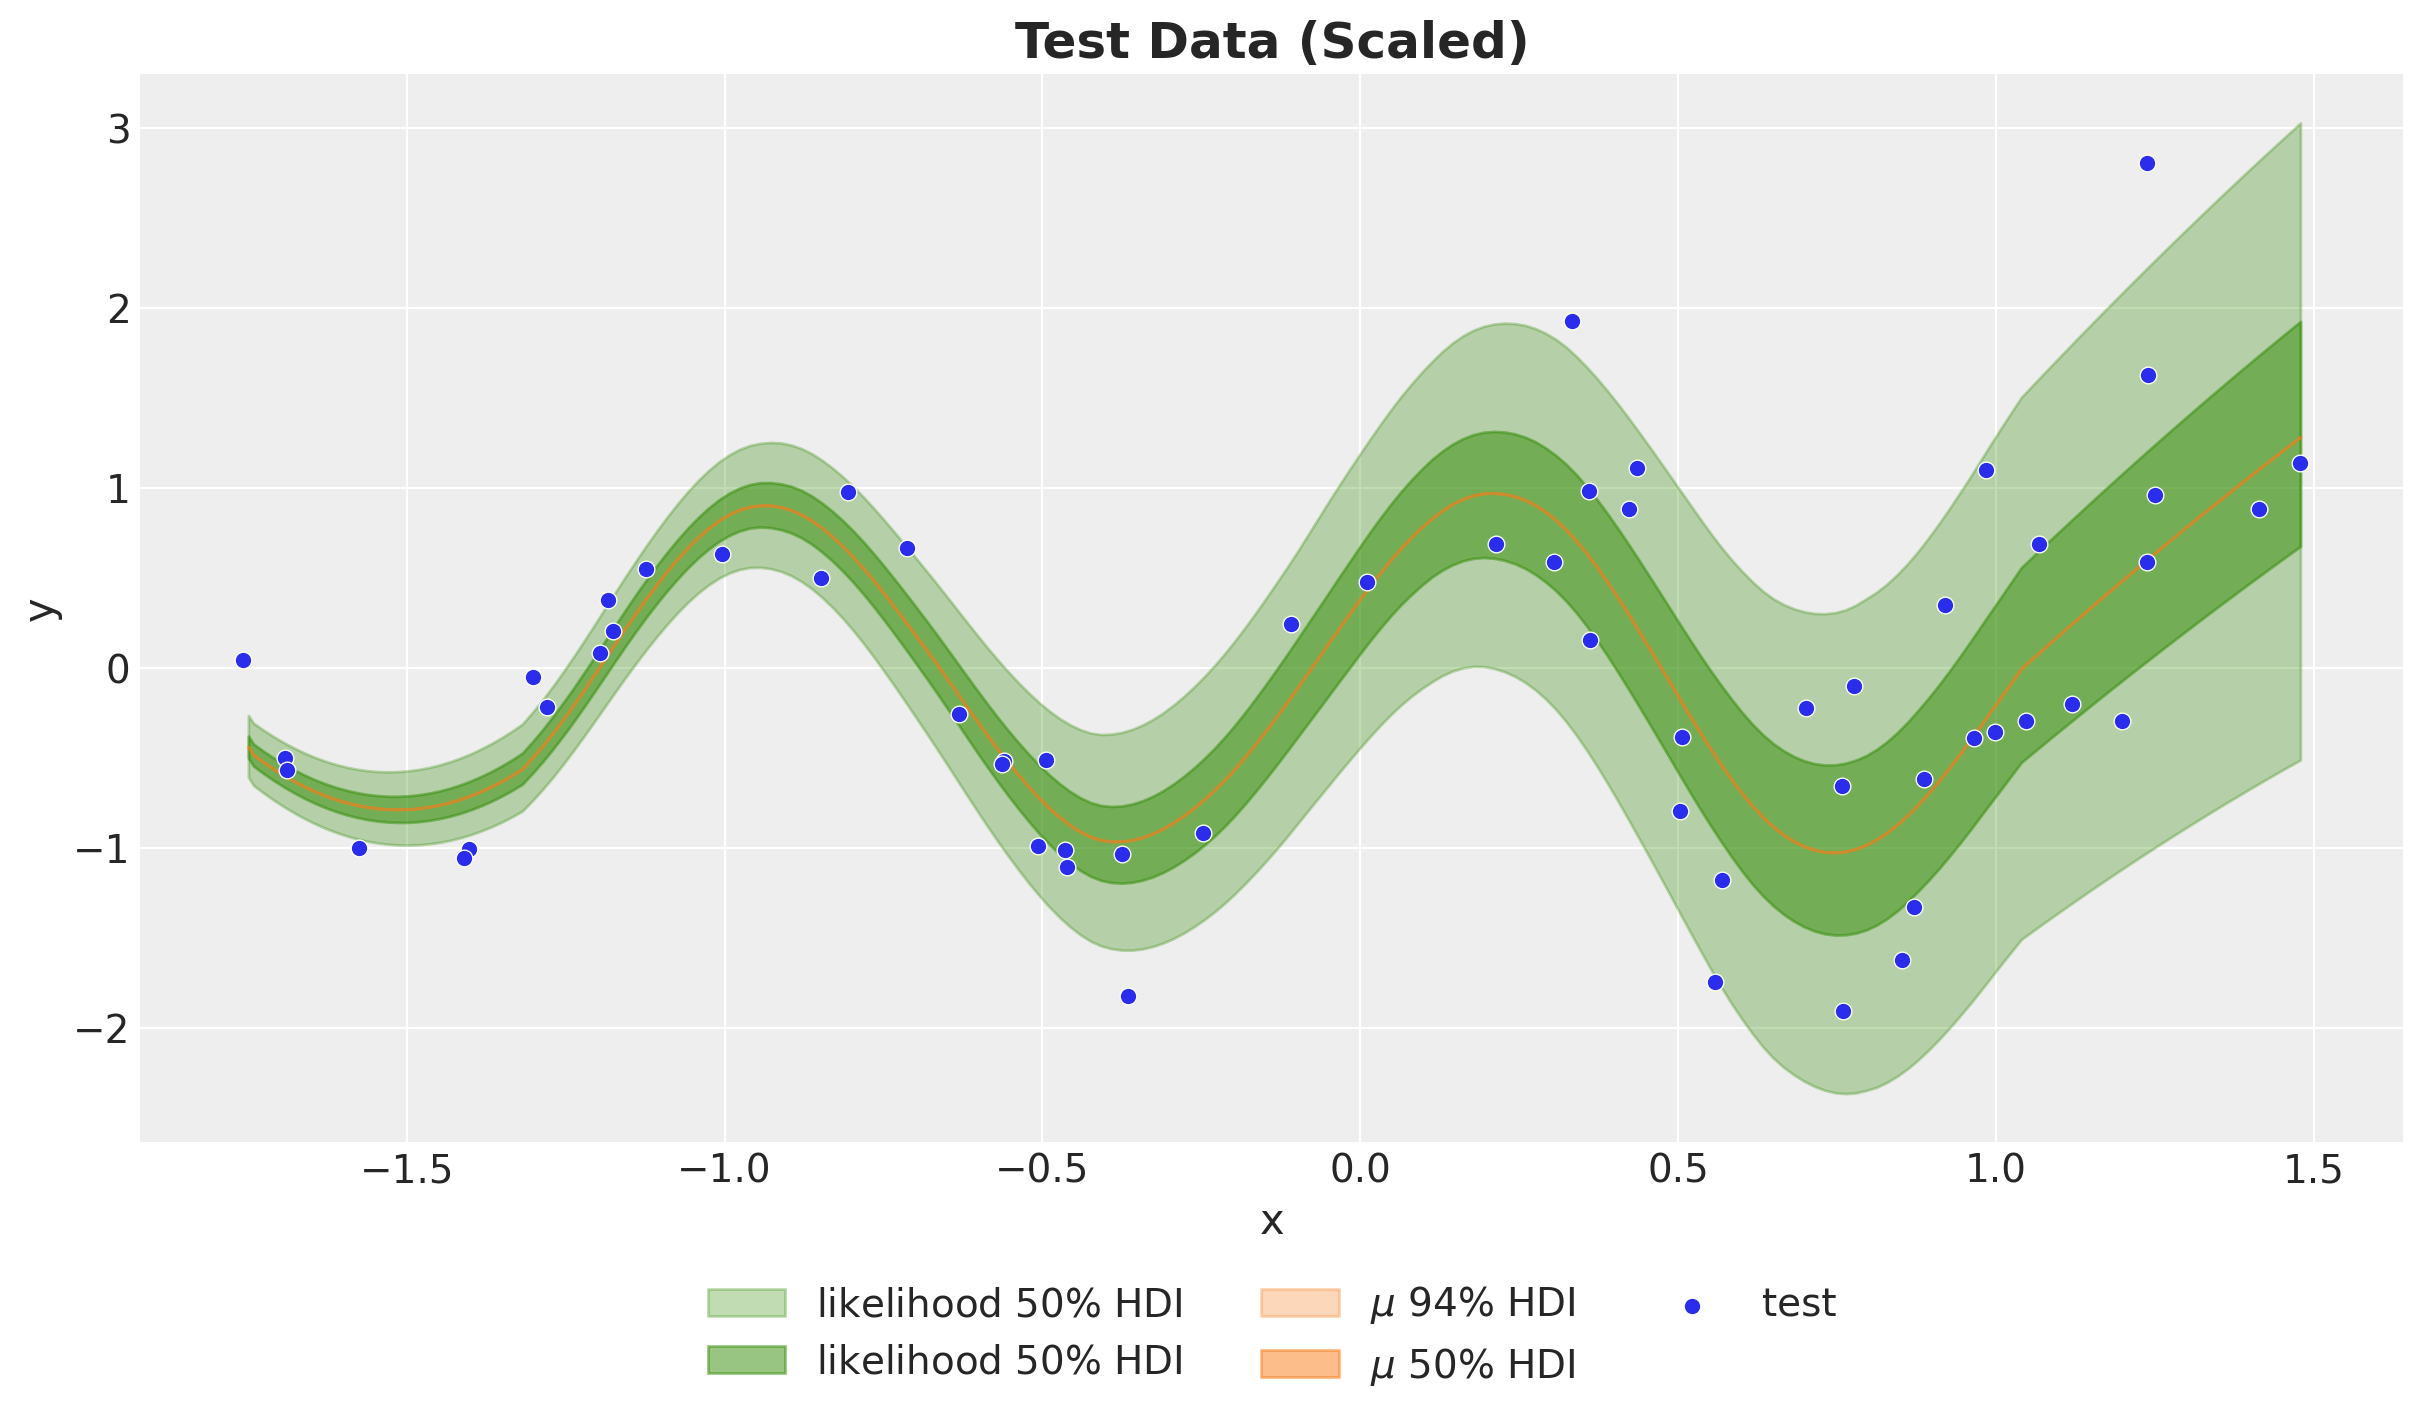

In [15]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=x_test_scaled.squeeze(),
    y=test_idata_svi.posterior_predictive["likelihood"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"label": r"likelihood $50\%$ HDI", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=x_test_scaled.squeeze(),
    y=test_idata_svi.posterior_predictive["likelihood"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"label": r"likelihood $50\%$ HDI", "alpha": 0.5},
    ax=ax,
)
az.plot_hdi(
    x=x_test_scaled.squeeze(),
    y=test_idata_svi.posterior_predictive["mu"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"label": r"$\mu$ $94\%$ HDI", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=x_test_scaled.squeeze(),
    y=test_idata_svi.posterior_predictive["mu"],
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"label": r"$\mu$ $50\%$ HDI", "alpha": 0.5},
    ax=ax,
)
sns.scatterplot(
    x=x_test_scaled.squeeze(), y=y_test_scaled, color="C0", label="test", ax=ax
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_title(label="Test Data (Scaled)", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")